<a href="https://colab.research.google.com/github/YuliiaChorna1/DataScience-10-Reccomender-systems/blob/main/10.1.1_extra_recsys_cloths_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
path = "/content/drive/MyDrive/Recommender_systems"

In [8]:
# Main Source: https://www.kaggle.com/datasets/rmisra/clothing-fit-dataset-for-size-recommendation?select=modcloth_final_data.json
# Extra Source: Addressing Marketing Bias in Product Recommendations - Mengting Wan, Jianmo Ni, Rishabh Misra, Julian McAuley - WSDM, 2020
# https://github.com/MengtingWan/merketBias

df = pd.read_json(path + "/modcloth_final_data.json", lines=True)

In [9]:
df.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82790 entries, 0 to 82789
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item_id         82790 non-null  int64  
 1   waist           2882 non-null   float64
 2   size            82790 non-null  int64  
 3   quality         82722 non-null  float64
 4   cup size        76535 non-null  object 
 5   hips            56064 non-null  float64
 6   bra size        76772 non-null  float64
 7   category        82790 non-null  object 
 8   bust            11854 non-null  object 
 9   height          81683 non-null  object 
 10  user_name       82790 non-null  object 
 11  length          82755 non-null  object 
 12  fit             82790 non-null  object 
 13  user_id         82790 non-null  int64  
 14  shoe size       27915 non-null  float64
 15  shoe width      18607 non-null  object 
 16  review_summary  76065 non-null  object 
 17  review_text     76065 non-null 

In [11]:
df = df[~df["user_id"].isna()]
df = df[~df["item_id"].isna()]
df = df[~df["quality"].isna()]
df = df[~df["review_text"].isna()]
df = df.reset_index()

In [12]:
len(df.item_id.unique())

1322

In [13]:
len(df.user_id.unique())

44811

In [14]:
len(df)

76000

## Non-personalized recommender systems

Popularity-based recommender systems: Popularity-based recommenders work by suggesting the most frequently purchased products to customers. As the name suggests, Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now.

### Frequency of purchase

Popularity-based recommenders work by suggesting the most frequently purchased products to customers. This vague idea can be turned into at least two concrete implementations:

- Check which articles are bought most often across all customers. Reccomend these articles to each customer. Source: https://towardsdatascience.com/how-to-build-popularity-based-recommenders-with-polars-cc7920ad3f68#:~:text=Popularity%Dbased%20recommenders%20work%20by,these%20articles%20to%20each%20customer.

In [15]:
items_popularity = df.groupby("item_id")["user_id"].count().sort_values(ascending=False)
items_popularity = items_popularity.reset_index()
items_popularity

,item_id,user_id
0,539980,2007
1,668696,1555
2,397005,1506
3,175771,1438
4,407134,1437
...,...,...
1317,542404,1
1318,541405,1
1319,214259,1
1320,536646,1


In [16]:
items_popularity.iloc[:3]["item_id"].to_list()

[539980, 668696, 397005]

In [17]:
popular_items = items_popularity.iloc[:3]["item_id"].to_list()

def present_recommended_products(popular_items: list):
    print("**Currently trending products**")
    print("")

    for index, item_id_ in enumerate(popular_items):
        slice_df = df[df["item_id"] == item_id_]
        print(f"Recommended item {index+1}/{len(popular_items)}: product {item_id_}")

        category = slice_df["category"].unique()[0]
        print(f"{category=}")

        slice_with_reviews = slice_df[~slice_df["review_text"].isna()]
        reviews_for_slice = list(slice_with_reviews["review_text"].unique())
        if len(reviews_for_slice) > 0:
            reviews = random.sample(reviews_for_slice, min(len(reviews_for_slice), 3))
            print(f"User reviews:")
            for review in reviews:
                print("-", review)
            print("...")
        else:
            print("There are no reviews for this product yet.")
        print("")

present_recommended_products(popular_items)

**Currently trending products**

Recommended item 1/3: product 539980
category='tops'
User reviews:
- Great basic for the wardrobe
- Love it.. Will be buying more colors!!!
- Like the color. Quality seems a little cheap for the price.
...

Recommended item 2/3: product 668696
category='bottoms'
User reviews:
- This skirt really is great! I wish I had ordered a size larger because I measured a little less carefully than I should have! Even though it's a little tight it still looks great though. The fabric is heavy and comfortable too. I would definitely recommend this, and I can't wait to wear it to work.
- The fabric is really heavy and I get sometimes tangled in the layers of it! But the skirt is beautiful, turns your body into a beautiful hourglass shape!
- So, this skirt is quite nice as most people have said, but I get the feeling some people might have been telling a few fibs about their waist size. My waist is about 3637 inches, and I had seen a lot of reviews by people with a sm

## Content-based Personalized recommendation systems

In [18]:
df.head(2)

,index,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,6725,152702,27.0,4,4.0,b,37.0,32.0,new,NaN,5ft 6in,avNYC,just right,small,668176,9.0,average,Too much ruching,"I liked the color, the silhouette, and the fab..."
1,6726,152702,26.0,4,5.0,c,36.0,34.0,new,NaN,5ft 6in,lanwei91,slightly short,fit,320759,7.5,NaN,Suits my body type!,From the other reviews it seems like this dres...


In [19]:
df_reviews = df[["item_id", "review_text", "category"]][~df["review_text"].isna()]
df_reviews.head()

,item_id,review_text,category
0,152702,"I liked the color, the silhouette, and the fab...",new
1,152702,From the other reviews it seems like this dres...,new
2,152702,I love the design and fit of this dress! I wo...,new
3,152702,I bought this dress for work it is flattering...,new
4,152702,This is a very professional look. It is Great ...,new


In [20]:
len(df_reviews)

76000

In [21]:
df_grouped = df_reviews.groupby(["item_id", "category"]).agg({'review_text': ' '.join})
df_grouped = df_grouped.reset_index()
df_grouped.head()

,item_id,category,review_text
0,152702,new,"I liked the color, the silhouette, and the fab..."
1,153494,new,I wanted to fit in this dress so bad so I made...
2,153798,new,Unfortunately the fabric is soooo thin and wri...
3,154411,new,My only complaint is that people notice when I...
4,154882,new,Most of the other reviews said size up one but...


Creating recommendations base don TF-IDF score:

*TFIDF score f or term i in document j = TF(i,j)* * *IDF(i)*

*where*

*IDF = Inverse Document Frequency*

*TF = Term Frequency*

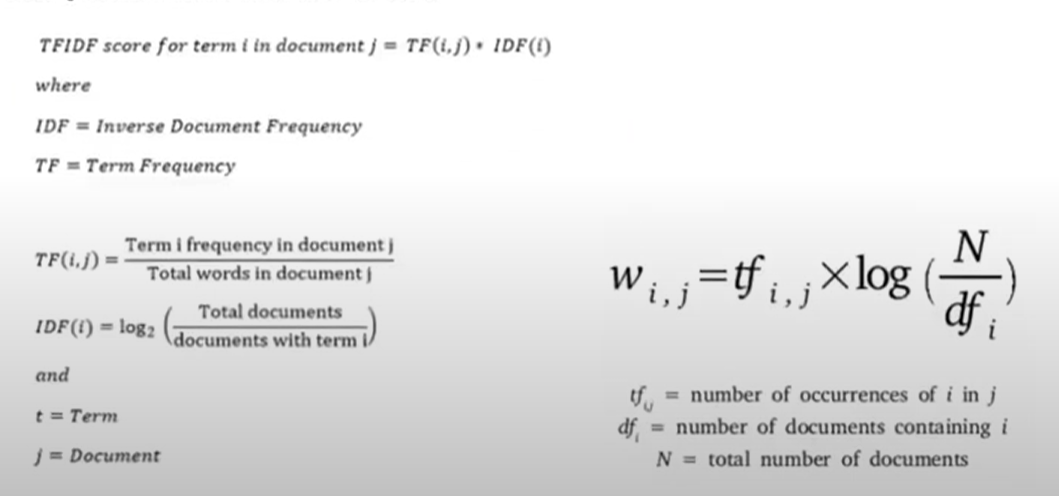

https://medium.com/@imamun/creating-a-tf-idf-in-python-e43f05e4d424

In [22]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_grouped["review_text"])
tfidf_matrix

<1322x22088 sparse matrix of type '<class 'numpy.float64'>'
	with 420695 stored elements in Compressed Sparse Row format>

In [23]:
len(df_grouped["review_text"])

1322

In [24]:
pd.DataFrame(tfidf_matrix.toarray())

,0,1,2,3,4,5,6,7,8,9,...,22078,22079,22080,22081,22082,22083,22084,22085,22086,22087
0,0.001489,0.0,0.0,0.0,0.0016,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.001636,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,0.000949,0.0,0.0,0.0,0.0000,0.0,0.001298,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1318,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1319,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1320,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [25]:
tfidf_vectorizer.vocabulary_

{'liked': 10972,
 'the': 19327,
 'color': 4221,
 'silhouette': 17207,
 'and': 1434,
 'fabric': 7073,
 'of': 13143,
 'this': 19449,
 'dress': 6173,
 'but': 3253,
 'ruching': 16247,
 'just': 10353,
 'looked': 11200,
 'bunchy': 3188,
 'ruined': 16261,
 'whole': 21489,
 'thing': 19418,
 'was': 21178,
 'so': 17764,
 'disappointed': 5804,
 'really': 15414,
 'waned': 21119,
 'to': 19692,
 'like': 10971,
 'runs': 16283,
 'little': 11066,
 'small': 17583,
 'would': 21798,
 'need': 12635,
 'size': 17309,
 'up': 20643,
 'make': 11502,
 'it': 10080,
 'workappropriate': 21735,
 'from': 8011,
 'other': 13428,
 'reviews': 15992,
 'seems': 16695,
 'either': 6473,
 'works': 21756,
 'for': 7818,
 'your': 22023,
 'body': 2703,
 'type': 20212,
 'or': 13370,
 'doesn': 5978,
 'have': 8970,
 'waist': 21058,
 'flabby': 7543,
 'tummy': 20099,
 'is': 10058,
 'perfect': 14002,
 'me': 11738,
 'detail': 5615,
 'around': 1702,
 'front': 8017,
 'hides': 9154,
 'everything': 6827,
 'clingyness': 4058,
 'makes': 11507

In [26]:
# Compute cosine similarity between user input and items
user_input = "Knee-long skirt made of silk"
user_tfidf = tfidf_vectorizer.transform([user_input])
user_df = pd.DataFrame(user_tfidf.toarray())
user_df

,0,1,2,3,4,5,6,7,8,9,...,22078,22079,22080,22081,22082,22083,22084,22085,22086,22087
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
tfidf_vectorizer.vocabulary_["silk"]

17211

In [28]:
user_df[tfidf_vectorizer.vocabulary_["silk"]]

,17211
0,0.726013


In [29]:
tfidf_vectorizer.idf_[tfidf_vectorizer.vocabulary_["silk"]]

4.855452653939752

In [30]:
cosine_similarities = linear_kernel(user_tfidf, tfidf_matrix).flatten()
cosine_similarities

array([0.04200172, 0.04524237, 0.        , ..., 0.02718421, 0.03061408,
       0.04886547])

In [31]:
# Get indices of items sorted by similarity
top_n = 3
item_indices = cosine_similarities.argsort()[:-top_n-1:-1]
print("indices:", item_indices)
# Get recommended item names
recommendations = df_grouped["item_id"].iloc[item_indices].tolist()
print("item_ids:", recommendations)

indices: [ 915 1105 1133]
item_ids: [605558, 701811, 714723]


In [32]:
def content_based_recommender(df, user_df, top_n=3):
    """
    Content-based recommender system using TF-IDF
    """
    # Combine relevant text features into a single string
    df["text_features"] = df["category"] + " " + df["review_text"]

    # TF-IDF Vectorization
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(df["text_features"])

    # Compute cosine_similarity between user input and items
    user_tfidf = tfidf_vectorizer.transform([user_input])
    cosine_similarities = linear_kernel(user_tfidf, tfidf_matrix).flatten()

    # Get indices of items sorted by similarity
    item_indices = cosine_similarities.argsort()[:-top_n-1:-1]

    # Get recommended item names
    recommendations = df["item_id"].iloc[item_indices].tolist()

    return recommendations

# Example usage
user_preferences = "Knee-long skirt made of silk"
recommended_products = content_based_recommender(df_grouped, user_preferences, top_n=3)
present_recommended_products(recommended_products)

**Currently trending products**

Recommended item 1/3: product 605558
category='tops'
User reviews:
- Very good quality. The fabric feels like silk. :)
- Just as pictured; soft material; looks and feels good quality. I usually wear an XL or L (I'm an apple shape) and got an L for this item and it fits well.
...

Recommended item 2/3: product 701811
category='bottoms'
User reviews:
- I liked the librarian look, with the plaid and strap details, however on, this skirt was not pretty.  I'm surprised at the cost with how cheaply made this skirt was.  I sent it back.  The length was great though, just wish it was a better quality.
- The skirt is made very well but is comically long. I am only 4'10 so I expect things to be bigger on me but it goes to my ankles. The material is sturdy and thick but not like wool so it can be used in spring and early summer too. Overall a great find just very long.
- When I received this skirt, I was pleasantly surprised on the quality of the skirt. The buckle

## Collaborative filtering (Collaborative recommender systems)

### Item-based filtering

Item-based collaborative filtering recommends items based om the similarity between items, patricularly their past interactions with users

In [33]:
# Sample dataset (user_id, item_id, rating)
data = {"user_id": [1, 1, 2, 2, 3, 3, 4, 4],
        "item_id": ["A", "B", "A", "C", "C", "D", "B", "D"],
        "rating": [5, 4, 3, 2, 4, 5, 1, 3]}

df_sample = pd.DataFrame(data)
df_sample

,user_id,item_id,rating
0,1,A,5
1,1,B,4
2,2,A,3
3,2,C,2
4,3,C,4
5,3,D,5
6,4,B,1
7,4,D,3


In [34]:
# Pivot the DataFrame to create a user-item matrix
user_item_matrix = df_sample.pivot_table(index="user_id", columns="item_id", values="rating", fill_value=0)
user_item_matrix

item_id,A,B,C,D
user_id,,,,
1,5.0,4.0,0.0,0.0
2,3.0,0.0,2.0,0.0
3,0.0,0.0,4.0,5.0
4,0.0,1.0,0.0,3.0


In [35]:
# Calculate cosine similarity between items
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity

array([[1.        , 0.83189033, 0.2300895 , 0.        ],
       [0.83189033, 1.        , 0.        , 0.12478355],
       [0.2300895 , 0.        , 1.        , 0.76696499],
       [0.        , 0.12478355, 0.76696499, 1.        ]])

In [36]:
# Retrieve the target item similarity scores with all other items
target_item = "A"
target_item_index = user_item_matrix.columns.get_loc(target_item)
print("item:", target_item, ", index:", target_item_index)
target_item_similarity = item_similarity[target_item_index]
print("item:", target_item, ", similarity scores:", target_item_similarity)

item: A , index: 0
item: A , similarity scores: [1.         0.83189033 0.2300895  0.        ]


In [37]:
# Get indices of items sorted by similarity
top_n = 2
item_indices = target_item_similarity.argsort()[:-top_n-1:-1]
print(f"indices: {item_indices}")

# Get recommended item ids
recommendations = user_item_matrix.columns[item_indices].tolist()
print("Recommended Items:", recommendations)

indices: [0 1]
Recommended Items: ['A', 'B']


In [38]:
def item_based_recommender(df, target_item, top_n=2):
    """
    Item-based collaborative filtering recommender system
    """
    # Pivot the DataFrame to create a user-item matrix
    user_item_matrix = df.pivot_table(index="user_id", columns="item_id", values="quality", fill_value=0) #df["rating"] = df["quality"]

    # Calculate cosine similarity between items
    item_similarity = cosine_similarity(user_item_matrix.T)

    #Retrieve the target item's similarity scores with all other items
    target_item_index = user_item_matrix.columns.get_loc(target_item)
    target_item_similarity = item_similarity[target_item_index]

    # Get indices of items sorted by similarity
    item_indices = target_item_similarity.argsort()[:-top_n-1:-1]

    # Get recommended item ids
    recommendations = user_item_matrix.columns[item_indices].tolist()

    return recommendations

In [39]:
target_item = 714723
recommended_products = item_based_recommender(df, target_item, top_n=4)
present_recommended_products(recommended_products)

**Currently trending products**

Recommended item 1/4: product 714723
category='bottoms'
User reviews:
- The skirt is very high quality and more beautiful in person. Hits right below the knee. Fits as expected. Love that it has pockets!!
- Perfect swishy skirt!  It's lined in a similar mustard color, very comfortable and very beautiful on  it's now my go to accent skirt.  The colors are wonderful for the last days of summer and will easily carry me into fall with the wine and berry colors.  I'm so glad I got this skirt.  It does run comfortably so it's not super snug, but it's also not really really loose.
- This skirt is so flowy and comfy. It has a beautiful silk underlining as well. The fabric isn't breathable at all, but because it's so flowy it doesn't matter. The pockets are a bit small, but still can hold a small set of keys or something. I usually wear a medium in skirts like this, and this one does fit a little bigger but still fits well for the style. Not too big to where it 

### User-based filtering

In [40]:
df_sample

,user_id,item_id,rating
0,1,A,5
1,1,B,4
2,2,A,3
3,2,C,2
4,3,C,4
5,3,D,5
6,4,B,1
7,4,D,3


In [41]:
# Pivot the DataFrame to create a user-item matrix
user_item_matrix = df_sample.pivot_table(index="user_id", columns="item_id", values="rating", fill_value=0)

# Calculate cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)
user_similarity

array([[1.        , 0.64972212, 0.        , 0.19754592],
       [0.64972212, 1.        , 0.34651847, 0.        ],
       [0.        , 0.34651847, 1.        , 0.7407972 ],
       [0.19754592, 0.        , 0.7407972 , 1.        ]])

In [42]:
item_similarity

array([[1.        , 0.83189033, 0.2300895 , 0.        ],
       [0.83189033, 1.        , 0.        , 0.12478355],
       [0.2300895 , 0.        , 1.        , 0.76696499],
       [0.        , 0.12478355, 0.76696499, 1.        ]])

In [43]:
print("item matrix")
print(user_item_matrix.T)
print("")
print("user matrix")
print(user_item_matrix)

item matrix
user_id    1    2    3    4
item_id                    
A        5.0  3.0  0.0  0.0
B        4.0  0.0  0.0  1.0
C        0.0  2.0  4.0  0.0
D        0.0  0.0  5.0  3.0

user matrix
item_id    A    B    C    D
user_id                    
1        5.0  4.0  0.0  0.0
2        3.0  0.0  2.0  0.0
3        0.0  0.0  4.0  5.0
4        0.0  1.0  0.0  3.0


In [44]:
# retrieve the target user's similarity scores with all other users
target_user = 1
target_user_index = user_item_matrix.index.get_loc(target_user)
target_user_similarity = user_similarity[target_user_index]

# Get indices of users sorted by similarity
top_n = 3
user_indices = target_user_similarity.argsort()[:-top_n-1:-1]
user_indices

array([0, 1, 3])

In [45]:
# Get recommened item ids based on similar users

#recommendations =
user_item_matrix.iloc[user_indices].mean().sort_values(ascending=False).index.tolist()

['A', 'B', 'D', 'C']

In [46]:
def user_based_recommender(df, target_user, top_n=2):
    """
    User-based collaborative filtering recommender system
    """
    # Pivot the DataFratme to create a user-item matrix
    df = df[~df["quality"].isna()]
    user_item_matrix = df.pivot_table(index="user_id", columns="item_id", values="quality", fill_value=0)

    # Calculate cosine similarity between users
    user_similarity = cosine_similarity(user_item_matrix)

    # Retrieve the target user's similarity scores with all other users
    taget_user_index = user_item_matrix.index.get_loc(target_user)
    target_user_similarity = user_similarity[target_user_index]

    # Get indices of users sorted by similarity
    user_indices = target_user_similarity.argsort()[:-top_n-1:-1]

    # Get recommended item ids based on similar users
    recommendations = user_item_matrix.iloc[user_indices].mean().sort_values(ascending=False).index.tolist()

    return recommendations

In [47]:
# Example usage
target_user = 320458
recommended_items = user_based_recommender(df, target_user, top_n=3)
print("Recommended Items:", recommended_items[:3])

In [48]:
present_recommended_products(recommended_items[:3])

## Hybrid Filtering

In [ ]:
# Collaborative filtering
collaborative_recommendations = user_based_recommender(df, target_user=320458, top_n=len(df["user_id"].unique()))

In [ ]:
# Content-based Filtering
content_recommendations = content_based_recommender(df_grouped, user_input="Knee-long skirt made of silk", top_n=len(df_grouped["item_id"].unique()))

In [ ]:
# Hybrid Recommendations (Combining Collaborative and Content-Based)
top_n = 3

hybrid_recommendations = set(collaborative_recommendations).union(set(content_recommendations))
hybrid_recommendations = [item for item in hybrid_recommendations]

print("Recommended Items:", hybrid_recommendations[:top_n])

In [ ]:
present_recommended_products(hybrid_recommendations[:top_n])